In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import genfromtxt
from scipy.optimize import linprog
plt.rcParams['figure.figsize'] = [10, 10]

### Generating Data
Here, I generate 2D data as follows: $x_i \sim N(0, 1)$
Then, I arbitrarily generate $w$ and $b$, the underlying model for classifying the data points. The general rule for classification is:
$$\langle w, x_i \rangle + b < 0 \Rightarrow y_i = -1$$
$$\langle w, x_i \rangle + b > 0 \Rightarrow y_i = +1$$

In order to make the data not linearly separable, I made $y_i$ take on the correct value with $S(|\langle w, x_i \rangle + b|)$ where $S$ is the sigmoid function i.e.:
$$S(x) = \frac{1}{1 + e^{-x}}$$
This makes mathematical sense because if $x = 0$, then arguably $y_i$ can take on $+1$ or $-1$ with equal probability, which is guaranteed by the properties of $S$.

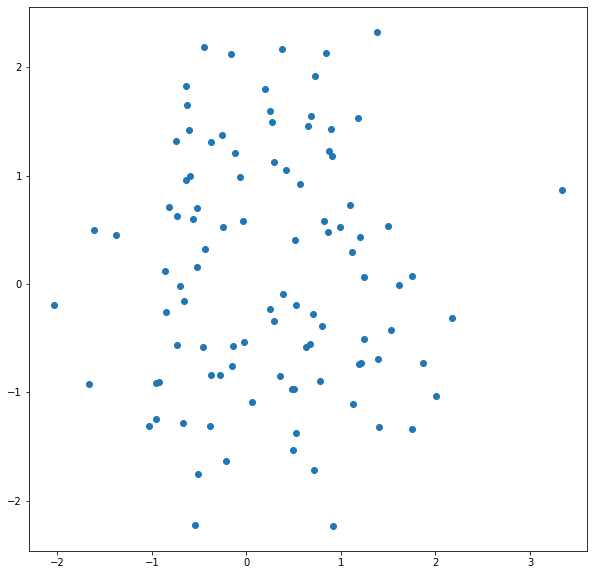

In [5]:
data = np.random.multivariate_normal(np.zeros(2), np.identity(2), 100)
plt.scatter(data[:, 0], data[:, 1])

In [25]:
w = np.random.normal(0, 1, 2)
b = np.random.normal(0, 1, 1)[0]
w, b

(array([-1.16047794, -0.34468155]), -0.6290106922401618)

In [26]:
np.random.rand()
sigmoid(np.abs(1))

0.7310585786300049

In [33]:
def sigmoid(x):
    return 1./(1. + np.exp(-x))

def color(x):
    if np.dot(x, w) + b > 0: 
        return 1 if np.random.rand() < sigmoid(np.abs(np.dot(x, w) + b)) else -1
    else: 
        return -1 if np.random.rand() < sigmoid(np.abs(np.dot(x, w) + b)) else 1

In [34]:
c = np.apply_along_axis(color, 1, data)
c

array([ 1, -1,  1, -1,  1, -1, -1,  1, -1,  1, -1, -1,  1, -1, -1,  1,  1,
        1,  1, -1,  1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,
       -1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1, -1, -1, -1,
        1,  1,  1, -1, -1,  1, -1, -1,  1,  1, -1, -1, -1,  1, -1, -1, -1,
       -1,  1, -1,  1, -1,  1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1,
        1, -1,  1, -1, -1, -1, -1, -1,  1,  1,  1, -1, -1, -1,  1])

In [35]:
data = np.concatenate((data, c.reshape(-1, 1)), axis=1)
data[0:5]

array([[ 0.71487946, -1.71371783,  1.        ],
       [ 0.91512512, -2.23270016, -1.        ],
       [-0.37330429, -0.83620892,  1.        ],
       [ 1.4008217 , -1.32017881, -1.        ],
       [-0.95467047, -0.91219522,  1.        ]])

In [36]:
def color_to_string(x):
    if x == 1: return "r"
    else: return "b"
np.vectorize(color_to_string)(data[:,2])

array(['r', 'b', 'r', 'b', 'r', 'b', 'b', 'r', 'b', 'r', 'b', 'b', 'r',
       'b', 'b', 'r', 'r', 'r', 'r', 'b', 'r', 'b', 'r', 'b', 'b', 'b',
       'b', 'b', 'b', 'b', 'b', 'b', 'r', 'r', 'b', 'r', 'r', 'r', 'b',
       'b', 'b', 'b', 'b', 'b', 'b', 'r', 'r', 'b', 'b', 'b', 'b', 'r',
       'r', 'r', 'b', 'b', 'r', 'b', 'b', 'r', 'r', 'b', 'b', 'b', 'r',
       'b', 'b', 'b', 'b', 'r', 'b', 'r', 'b', 'r', 'b', 'b', 'b', 'r',
       'b', 'b', 'b', 'b', 'b', 'b', 'b', 'r', 'b', 'r', 'b', 'b', 'b',
       'b', 'b', 'r', 'r', 'r', 'b', 'b', 'b', 'r'], dtype='<U1')

In [47]:
def line_plot(x):
    grad = -(w[0]/w[1])
    yinter = - b/w[1]
    return grad*x + yinter

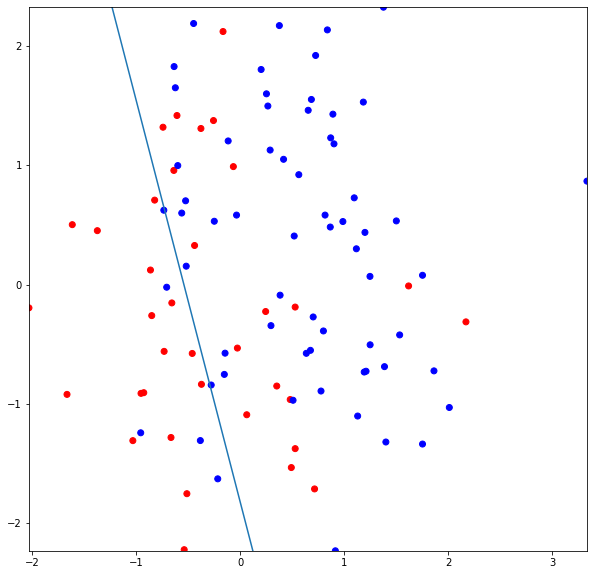

In [48]:
plt.scatter(data[:,0], data[:,1], c=np.vectorize(color_to_string)(data[:,2]))
t = np.arange(np.min(data[:, 0]), np.max(data[:, 0]), 0.01)
plt.plot(t, np.vectorize(line_plot)(t))
plt.xlim([np.min(data[:, 0]), np.max(data[:, 0])])
plt.ylim([np.min(data[:, 1]), np.max(data[:, 1])])
plt.show()

### SVM
The main difference is that now, the data is not linearly separable. The key idea now is, we must allow at least some of the data to exceed the threshold. This can be done by introducing slack variables $e$.

Previously in linear separable SVM, we introduce the hard rule that:
1. If $y_i = +1$, $\langle w, x_i \rangle + b \geq 1$
2. If $y_i = -1$, $\langle w, x_i \rangle + b \leq -1$

Now, we relax these two rules by introducing $e_i$ which you can think of as "breathing space":
1. If $y_i = +1$, $\langle w, x_i \rangle + b \geq 1 - e_i$
2. If $y_i = -1$, $\langle w, x_i \rangle + b \leq -1 + e_i$

Intuitively, if a point $x_i$ is classified as $y_i = +1$ but $\langle w, x_i \rangle + b \leq 1$, then we give it a breathing space of $e_i > 0$ to ensure that it fulfils $\langle w, x_i \rangle + b \geq 1 - e_i$. 

Conversely, if a point $x_i$ is classified as $y_i = -1$ but $\langle w, x_i \rangle + b \geq -1$, then we give it a breathing space of $e_i > 0$ to ensure that it fulfils $\langle w, x_i \rangle + b \leq -1 + e_i$. 

This way, our optimization problem turns into one where in addition to maximizing the margin $\frac{2}{\|w\|^2_2}$, we also want to minimize the components of $e$ i.e. minimize the amount of slack we give to the data for being wrong.

The choice of how we want to minimize the components of $e$ is an art. Over here, we try to minimize the $l_1$ norm of $e$, because the minimization of $l_1$ norm tends to encourage sparsity in the solution i.e. more components which are $0$ rather than positive value.

Hence, SVM can be written as an optimization problem:
$$\text{min}_{w,b,e} \| w \|_2^2 + \|e\|_1 $$
subject to: $\langle w, x_i \rangle + b \geq 1 - e_i$ for $y_i = +1$, $\langle w, x_i \rangle + b \leq -1 + e_i$  for $y_i = -1$, $e_i \geq 0$

The constraints can be collected into the standard form $-y_i(\langle w, x_i \rangle + b) - e_i + 1 \leq 0$, $-e \leq 0$

In [49]:
what = cp.Variable(2)
bhat = cp.Variable(1)
ehat = cp.Variable(data.shape[0])

objective = cp.Minimize(cp.sum_squares(what) + cp.norm(ehat, 1))
constraints = []
for i in range(len(data)):
    yi = data[i][2]
    xi = data[i][0:2]
    constraints += [-yi*(xi[0]*what[0] + xi[1]*what[1] + bhat) - ehat[i] + 1 <= 0]
constraints += [-ehat <= 0]

In [50]:
problem = cp.Problem(objective, constraints)
result = problem.solve()
what.value, bhat.value, ehat.value

(array([-1.0542274 , -0.41166648]),
 array([-0.26308105]),
 array([ 1.31124132e+00,  6.91335075e-01,  5.25291747e-01, -2.12140296e-07,
         1.72339095e-07, -1.18764005e-07,  3.69241771e-01,  2.96570639e+00,
         4.74463144e-09,  1.37293906e+00, -1.52221024e-08, -1.49596420e-07,
         8.79630095e-01,  2.85323566e-01,  7.81353101e-01,  1.73783179e-07,
         9.83960614e-01,  6.86794593e-01,  1.40344343e+00, -1.50775369e-07,
         2.60433987e-08,  7.10404450e-08,  1.02327829e+00,  7.15464383e-01,
         7.40326760e-08,  6.00744337e-01, -2.99032547e-08,  1.63580467e+00,
         8.14326082e-08,  5.34359067e-01, -1.46553895e-07, -2.13459041e-07,
        -1.29737036e-05,  1.74250890e+00, -2.55879110e-08, -2.82144980e-06,
         1.60069174e+00,  3.42328314e+00,  8.28807045e-08,  1.08968055e-01,
         2.25789941e+00, -1.43758597e-07,  3.08256128e-01,  3.29448556e-08,
         6.54803448e-01,  7.97430888e-08,  1.28313904e+00, -1.27704083e-07,
         1.49192053e+00,  7.2

### Results

In [51]:
def prediction(x):
    grad = -(what.value[0]/what.value[1])
    yinter = - bhat.value/what.value[1]
    return grad*x + yinter

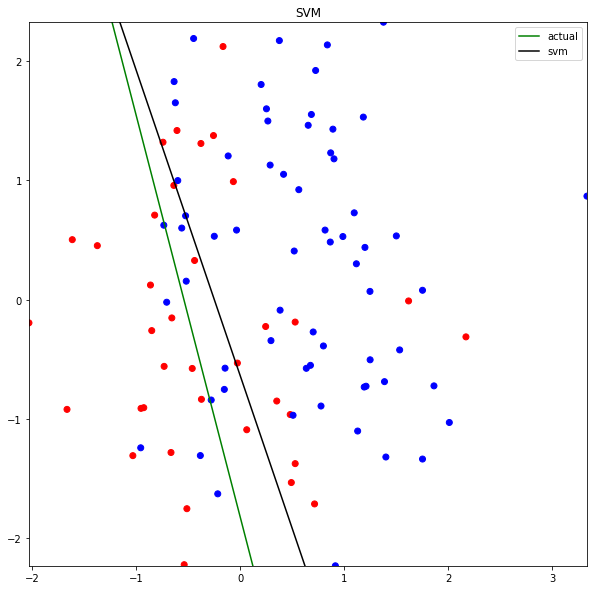

In [57]:
plt.scatter(data[:,0], data[:,1], c=np.vectorize(color_to_string)(data[:,2]))
t = np.arange(np.min(data[:, 0]), np.max(data[:, 0]), 0.01)
plt.plot(t, np.vectorize(line_plot)(t), color='green', label='actual')
plt.plot(t, np.vectorize(prediction)(t), color='black', label='svm')
plt.xlim([np.min(data[:, 0]), np.max(data[:, 0])])
plt.ylim([np.min(data[:, 1]), np.max(data[:, 1])])
plt.title("SVM")
plt.legend()
plt.show()